In [96]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, confusion_matrix
from sklearn.decomposition import PCA

In [97]:
data = pd.read_csv('game_log.csv')
data = data.drop(columns='closest_body_distance')
# Clean up the last column by removing quotes and converting everything to uppercase
data.iloc[:, -1] = data.iloc[:, -1].apply(lambda x: str(x).replace("'", "").upper())
data = data.drop_duplicates()
data

,head_x,head_y,tail_x,tail_y,food_x,food_y,direction,snake_length,score,head_top_distance,...,body_turns,moves_since_eating,total_moves,enclosed_spaces_count,largest_enclosed_space,tail_reachable,food_eaten,game_ended,time_elapsed,action
0,16,10,15,10,6,19,1,2,1,10,...,0,45,45,0,0,True,False,False,4.692,UP
1,16,7,16,8,6,19,1,2,1,7,...,0,48,48,0,0,True,False,False,4.970,UP
2,16,3,16,4,6,19,1,2,1,3,...,0,52,52,0,0,True,False,False,5.363,UP
3,16,0,16,1,6,19,1,2,1,0,...,0,55,55,0,0,True,False,False,5.667,UP
4,16,15,16,16,6,19,4,2,1,15,...,0,80,80,0,0,True,False,False,8.108,RIGHT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8313,11,10,11,7,13,8,4,4,3,10,...,0,144,144,0,0,True,False,False,14.828,RIGHT
8314,13,10,11,9,13,8,1,4,3,10,...,1,146,146,0,0,True,False,False,15.010,UP
8315,13,8,11,10,1,3,3,5,4,8,...,1,147,147,0,0,True,False,False,15.194,LEFT
8316,9,8,13,8,1,3,3,5,4,8,...,0,151,151,0,0,True,False,False,15.613,LEFT


In [80]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
action_encoded = one_hot_encoder.fit_transform(data[['action']])
action_columns = one_hot_encoder.get_feature_names_out(['action'])
action_encoded_df = pd.DataFrame(action_encoded, columns=action_columns)
action_encoded_df

,action_DOWN,action_LEFT,action_RIGHT,action_UP
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
8313,0.0,0.0,1.0,0.0
8314,0.0,0.0,0.0,1.0
8315,0.0,1.0,0.0,0.0
8316,0.0,1.0,0.0,0.0


In [81]:
data = pd.concat([data.drop(columns=['action']), action_encoded_df], axis=1)
data = data.loc[:, data.nunique() > 1]
X = data.drop(columns=action_columns)  # Features without the one-hot encoded 'action' columns
y = data[action_columns]  # The target is the one-hot encoded 'action' columns
y

,action_DOWN,action_LEFT,action_RIGHT,action_UP
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
8313,0.0,0.0,1.0,0.0
8314,0.0,0.0,0.0,1.0
8315,0.0,1.0,0.0,0.0
8316,0.0,1.0,0.0,0.0


In [82]:
first_rows = np.array(X.iloc[0])
categorical_cols = []

# Identify numeric columns
numeric_cols = []

for i in range(len(first_rows)-1):
    if(type(first_rows[i]) == str or type(first_rows[i])== np.bool_):
        print(type(first_rows[i]))
        categorical_cols.append(i)
    else:
        numeric_cols.append(i)

categorical_cols
for i in categorical_cols:
    print(first_rows[i])

<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
<class 'numpy.bool_'>
False
False
True
False
False
True
True
False


In [83]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df

,head_x,head_y,tail_x,tail_y,food_x,food_y,direction,snake_length,score,head_top_distance,...,food_above,food_below,food_left,food_right,body_segments_same_row,body_segments_same_column,body_turns,moves_since_eating,total_moves,time_elapsed
0,0.842105,0.526316,0.789474,0.526316,0.315789,1.000000,0.000000,0.012987,0.012987,0.526316,...,0.0,1.0,1.0,0.0,0.052632,0.000000,0.000000,0.012600,0.012600,0.012656
1,0.842105,0.368421,0.842105,0.421053,0.315789,1.000000,0.000000,0.012987,0.012987,0.368421,...,0.0,1.0,1.0,0.0,0.000000,0.052632,0.000000,0.013522,0.013522,0.013491
2,0.842105,0.157895,0.842105,0.210526,0.315789,1.000000,0.000000,0.012987,0.012987,0.157895,...,0.0,1.0,1.0,0.0,0.000000,0.052632,0.000000,0.014751,0.014751,0.014671
3,0.842105,0.000000,0.842105,0.052632,0.315789,1.000000,0.000000,0.012987,0.012987,0.000000,...,0.0,1.0,1.0,0.0,0.000000,0.052632,0.000000,0.015673,0.015673,0.015583
4,0.842105,0.789474,0.842105,0.842105,0.315789,1.000000,1.000000,0.012987,0.012987,0.789474,...,0.0,1.0,1.0,0.0,0.000000,0.052632,0.000000,0.023356,0.023356,0.022913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8313,0.578947,0.526316,0.578947,0.368421,0.684211,0.421053,1.000000,0.038961,0.038961,0.526316,...,1.0,0.0,0.0,1.0,0.000000,0.157895,0.000000,0.043024,0.043024,0.043090
8314,0.684211,0.526316,0.578947,0.473684,0.684211,0.421053,0.000000,0.038961,0.038961,0.526316,...,1.0,0.0,0.0,0.0,0.105263,0.000000,0.083333,0.043639,0.043639,0.043636
8315,0.684211,0.421053,0.578947,0.526316,0.052632,0.157895,0.666667,0.051948,0.051948,0.421053,...,1.0,0.0,1.0,0.0,0.000000,0.105263,0.083333,0.043946,0.043946,0.044189
8316,0.473684,0.421053,0.684211,0.421053,0.052632,0.157895,0.666667,0.051948,0.051948,0.421053,...,1.0,0.0,1.0,0.0,0.210526,0.000000,0.000000,0.045175,0.045175,0.045447


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)


In [85]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
y_test

(6654, 33)
(1664, 33)
(6654, 4)
(1664, 4)


,action_DOWN,action_LEFT,action_RIGHT,action_UP
5283,0.0,0.0,0.0,1.0
736,1.0,0.0,0.0,0.0
7545,0.0,0.0,0.0,1.0
3139,1.0,0.0,0.0,0.0
2317,0.0,1.0,0.0,0.0
...,...,...,...,...
5929,0.0,0.0,0.0,1.0
7698,0.0,1.0,0.0,0.0
7081,0.0,0.0,0.0,1.0
2388,0.0,0.0,0.0,1.0


In [86]:
# Define the neural network model
model = Sequential([
    Dense(5, activation='relu',input_dim = X_train.shape[1]),
    Dense(5, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=130, validation_split=0.1)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3218 - loss: 1.3364 - val_accuracy: 0.4354 - val_loss: 1.2590
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4636 - loss: 1.2353 - val_accuracy: 0.4670 - val_loss: 1.1504
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5170 - loss: 1.1237 - val_accuracy: 0.5946 - val_loss: 1.0351
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6103 - loss: 1.0186 - val_accuracy: 0.7312 - val_loss: 0.9165
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7420 - loss: 0.9006 - val_accuracy: 0.7733 - val_loss: 0.7959
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.7783 - val_accuracy: 0.8093 - val_loss: 0.6928
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8031 - loss: 0.6904 - val_accuracy: 0.8348 - val_loss: 0.6101
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8194 - loss: 0.6085 - val_accuracy: 0.8483 - val_loss: 0.5494
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


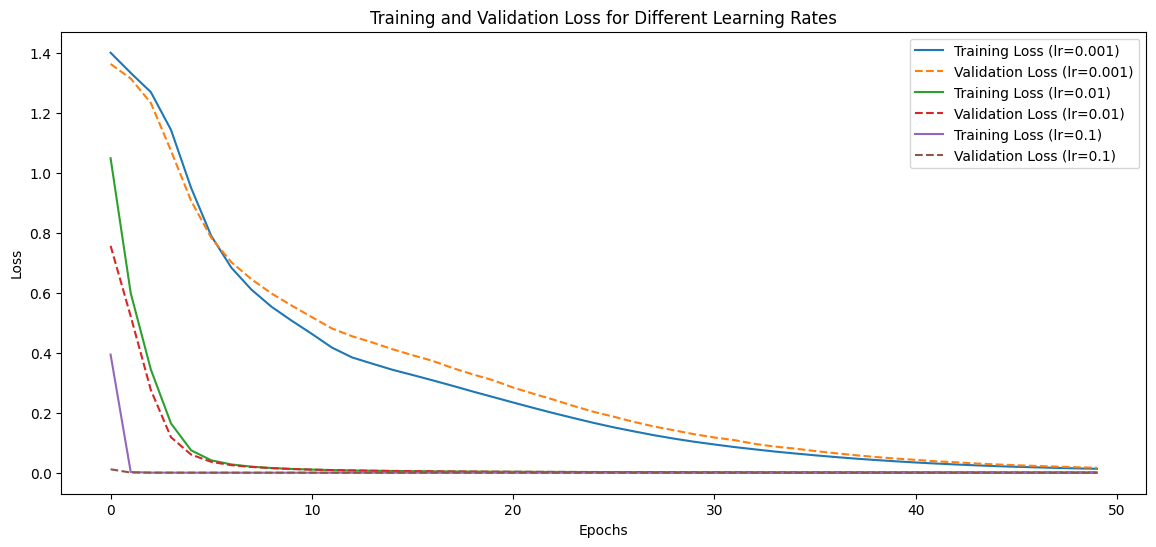

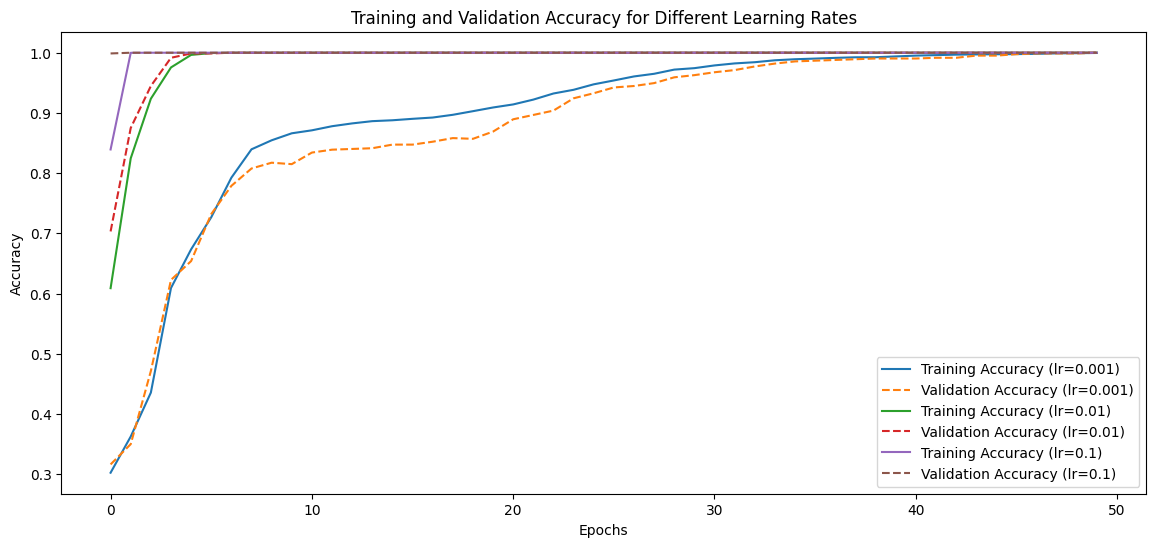

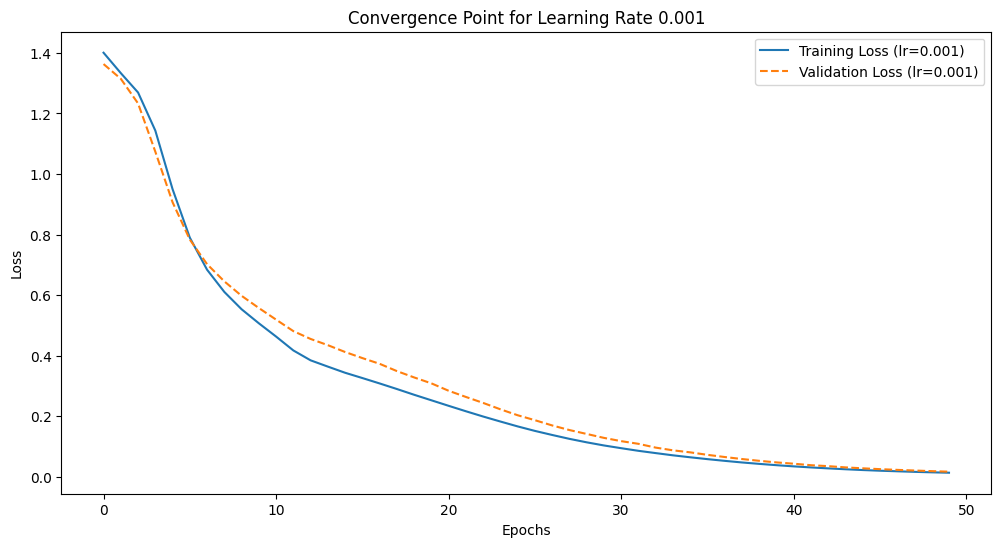

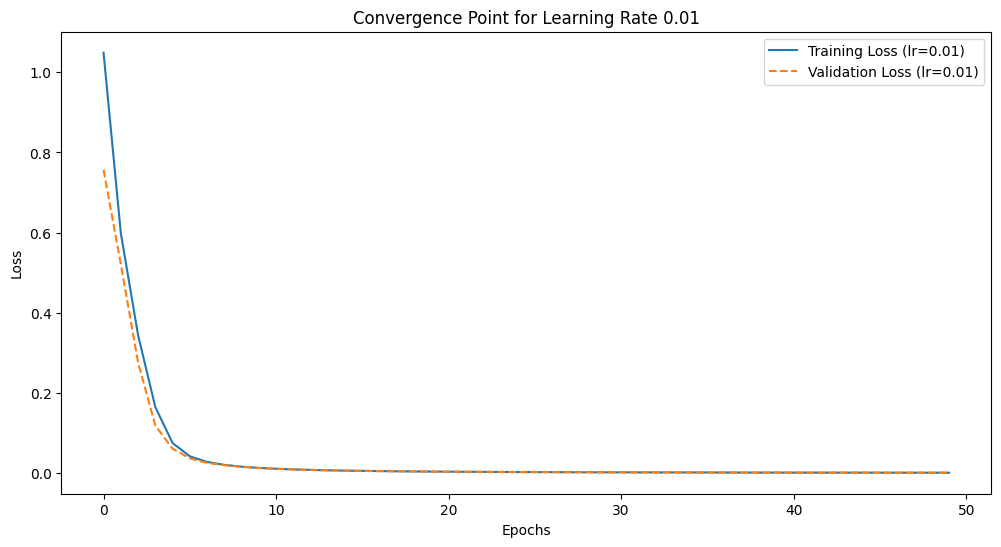

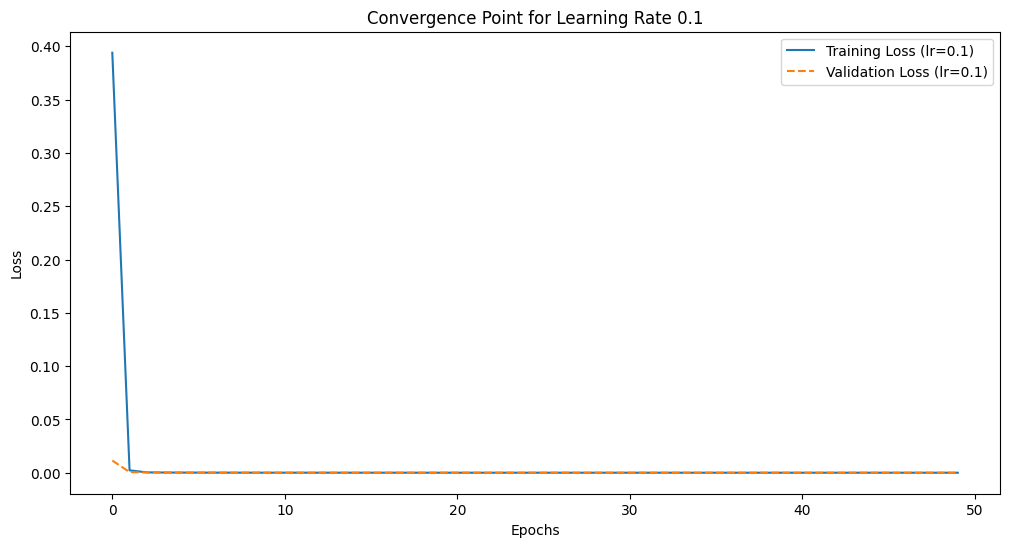

In [95]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define function to train model with variable hyperparameters
def train_model(learning_rate=0.001, optimizer='adam', epochs=20, batch_size=130):
    # Set optimizer with given learning rate
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    # Define model
    model = Sequential([
        Dense(5, activation='relu', input_dim=X_scaled_df.shape[1]),
        Dense(5, activation='relu'),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(X_scaled_df, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)
    return history

# Varying learning rates for experimentation
learning_rates = [0.001, 0.01, 0.1]
histories = {}

# Run training for each learning rate and collect history
for lr in learning_rates:
    history = train_model(learning_rate=lr, epochs=50)  # Increased epochs for better convergence visualization
    histories[lr] = history

# Plot training and validation loss curves for each learning rate
plt.figure(figsize=(14, 6))
for lr, history in histories.items():
    plt.plot(history.history['loss'], label=f'Training Loss (lr={lr})')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'Validation Loss (lr={lr})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Different Learning Rates')
plt.legend()
plt.show()

# Plot training and validation accuracy curves for each learning rate
plt.figure(figsize=(14, 6))
for lr, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'Training Accuracy (lr={lr})')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'Validation Accuracy (lr={lr})')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Different Learning Rates')
plt.legend()
plt.show()

# Identify and plot the convergent error point (epoch where overfitting begins)
for lr, history in histories.items():
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Find epoch where validation loss starts diverging significantly from training loss
    convergence_epoch = None
    for epoch in range(1, len(train_loss)):
        if val_loss[epoch] > val_loss[epoch - 1] and val_loss[epoch] > train_loss[epoch]:
            convergence_epoch = epoch
            break

    # Plot the loss curves and mark the convergence epoch
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label=f'Training Loss (lr={lr})')
    plt.plot(val_loss, linestyle='--', label=f'Validation Loss (lr={lr})')
    if convergence_epoch:
        plt.axvline(convergence_epoch, color='red', linestyle=':', label=f'Convergence Epoch (lr={lr})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Convergence Point for Learning Rate {lr}')
    plt.legend()
    plt.show()


In [87]:
y_train

,action_DOWN,action_LEFT,action_RIGHT,action_UP
3375,0.0,0.0,1.0,0.0
937,1.0,0.0,0.0,0.0
6883,0.0,0.0,0.0,1.0
5266,0.0,1.0,0.0,0.0
6223,0.0,1.0,0.0,0.0
...,...,...,...,...
5734,0.0,1.0,0.0,0.0
5191,0.0,0.0,0.0,1.0
5390,0.0,0.0,0.0,1.0
860,0.0,0.0,1.0,0.0


In [88]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test.values, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)

# Ensure there are no NaNs
if np.isnan(y_test.values).any() or np.isnan(y_pred).any():
    raise ValueError("Input contains NaN.")

# Calculate R² score
r2 = r2_score(y_test.values, y_pred, multioutput='uniform_average')

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'R² Score: {r2:.2f}')

# Print detailed classification report
print("Performance Metrics:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['DOWN', 'LEFT', 'RIGHT', 'UP']))


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1-Score: 0.89
R² Score: 0.80
Performance Metrics:
              precision    recall  f1-score   support

        DOWN       0.85      0.88      0.87       416
        LEFT       0.89      0.90      0.90       444
       RIGHT       0.91      0.92      0.91       392
          UP       0.91      0.88      0.90       412

    accuracy                           0.89      1664
   macro avg       0.89      0.89      0.89      1664
weighted avg       0.89      0.89      0.89      1664



In [89]:
y_train

,action_DOWN,action_LEFT,action_RIGHT,action_UP
3375,0.0,0.0,1.0,0.0
937,1.0,0.0,0.0,0.0
6883,0.0,0.0,0.0,1.0
5266,0.0,1.0,0.0,0.0
6223,0.0,1.0,0.0,0.0
...,...,...,...,...
5734,0.0,1.0,0.0,0.0
5191,0.0,0.0,0.0,1.0
5390,0.0,0.0,0.0,1.0
860,0.0,0.0,1.0,0.0


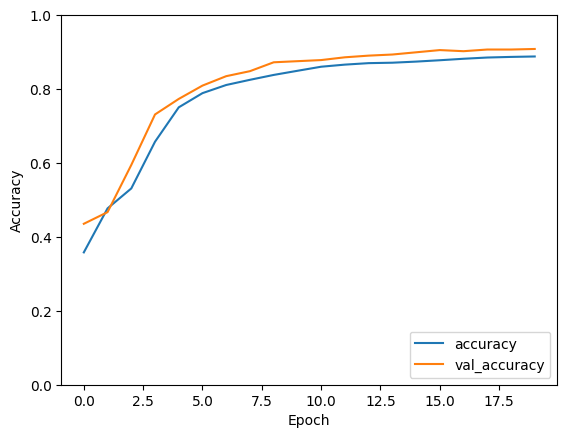

In [90]:
# Plot training history if needed
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

